<a href="https://colab.research.google.com/github/rtealwitter/dl-demos/blob/main/demo04-convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Visualizing Convolutions

Convolutions are an efficient way to extract information from image-like data.

Today we will:

* Get a better sense for what convolutions look like when there are multiple input and output channels

* Visualize the kernels actually learned by models.

The figures are from [d2l.ai](https://d2l.ai/chapter_convolutional-neural-networks/conv-layer.html#the-cross-correlation-operation) and the demo itself is from Karthik Garimella [here](https://github.com/kvgarimella/dl-demos/blob/d8bdb407ddf39f9a45030d9c1d6873d1afffa077/demo04b-visualize-alexnet.ipynb).

### Convolutions in Higher Dimensions

#### Standard Convolution
In the simplest case, the input image has a single channel (grayscale image) and so does the output. To produce an output pixel, we perform an element-wise multiplication of the filter weights with a patch of the image and take the sum.

![](https://d2l.ai/_images/correlation.svg)

Here, a $3 \times 3$ input convolved with a $2 \times 2$ kernel gives a $2 \times 2$ output.

#### Multiple Channels Input

We can extend to multiple input channels. We have a kernel for each channel to dimension. To produce an output pixel, we perform the convolution operation per channel and then sum the resulting value from each channel.

![](https://d2l.ai/_images/conv-multi-in.svg)

Here, a $2 \times 3 \times 3$ input convolved with a $2 \times 2 \times 2$ kernel gives a $2 \times 2$ output.

#### Multiple Channels Input and Output

To produce multiple output channels, we now have a set of kernels for each output channel.

![](https://d2l.ai/_images/conv-1x1.svg)

Here, a $3 \times 3 \times 3$ input convolved with a $2 \times 3 \times 2 \times 3$ kernel gives a $2 \times 3 \times 3$ output.



### Visualizing AlexNet

In [14]:
# Importing libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
import requests
from io import BytesIO

import torchsummary

# Limit warnings LOL
import logging
logger = logging.getLogger()
logger.setLevel(100)

We'll use the following functions for plotting.

In [15]:
## produces an 8 by 8 set of convolution kernels.
def plot_first_layer_filters(conv_layer, nrows=8, ncols=8):
    fig, axs = plt.subplots(nrows, ncols, figsize=(15, 15))
    plt.axis('off')
    idx = 0
    for i in range(len(axs)):
        for j in range(len(axs[i])):
            # Here, we get the weights of the kernels and plot them.
            curr_filter = conv_layer.weight.data[idx].permute(1,2,0).clone() # (C, H, W) -> (H, W, C)
            axs[i,j].set_axis_off()
            axs[i,j].imshow(curr_filter, vmin=curr_filter.min(), vmax=curr_filter.max()) # plot kernel
            idx += 1

## produces an 8 by 8 set of feature maps after passing an image through the first conv layer
def plot_first_layer_activations(output, nrows=8, ncols=8):
    fig, axs = plt.subplots(nrows,ncols, figsize=(15, 15))
    plt.axis('off')
    idx = 0
    for i in range(len(axs)):
        for j in range(len(axs[i])):
            # Here, we get the values in the output and plot them.
            curr_activation = output[idx].clone()
            axs[i,j].set_axis_off()
            axs[i,j].imshow(curr_activation)
            idx += 1

We'll load the AlexNet model.

In [16]:
alexnet = torchvision.models.alexnet() # untrained
alexnet_pretrained = torchvision.models.alexnet(weights='DEFAULT') # trained

The model is pretty big. Let's print it out to take a look.

In [17]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

We can more easily process the input by using the `torchsummary` package. We'll imagine that we're applying AlexNet to input images of size $3 \times 224 \times 224$. (This is a color image with $224 \times 224$ pixels.)

In [18]:
torchsummary.summary(alexnet, (3, 224, 224), 1)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 64, 55, 55]          23,296
              ReLU-2            [1, 64, 55, 55]               0
         MaxPool2d-3            [1, 64, 27, 27]               0
            Conv2d-4           [1, 192, 27, 27]         307,392
              ReLU-5           [1, 192, 27, 27]               0
         MaxPool2d-6           [1, 192, 13, 13]               0
            Conv2d-7           [1, 384, 13, 13]         663,936
              ReLU-8           [1, 384, 13, 13]               0
            Conv2d-9           [1, 256, 13, 13]         884,992
             ReLU-10           [1, 256, 13, 13]               0
           Conv2d-11           [1, 256, 13, 13]         590,080
             ReLU-12           [1, 256, 13, 13]               0
        MaxPool2d-13             [1, 256, 6, 6]               0
AdaptiveAvgPool2d-14             [1, 25

Let's visualize the weights from the first layer.

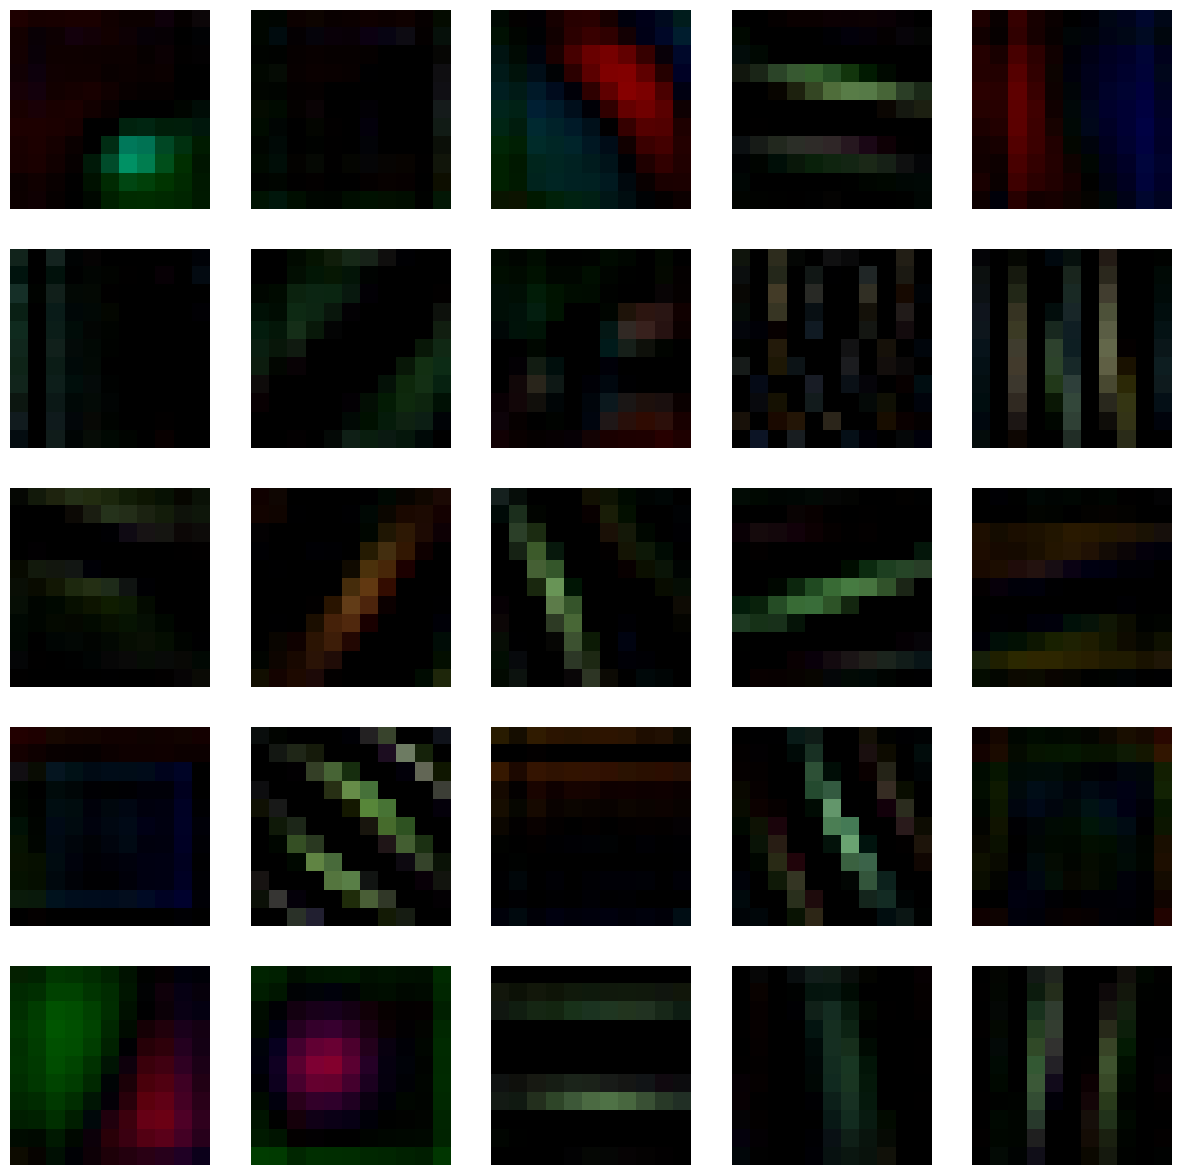

In [25]:
trained_conv_layer = alexnet_pretrained.features[0]
plot_first_layer_filters(trained_conv_layer, nrows=8, ncols=8)

These are pretty funky. We can check that they're not random by plotting the weights from the untrained AlexNet.

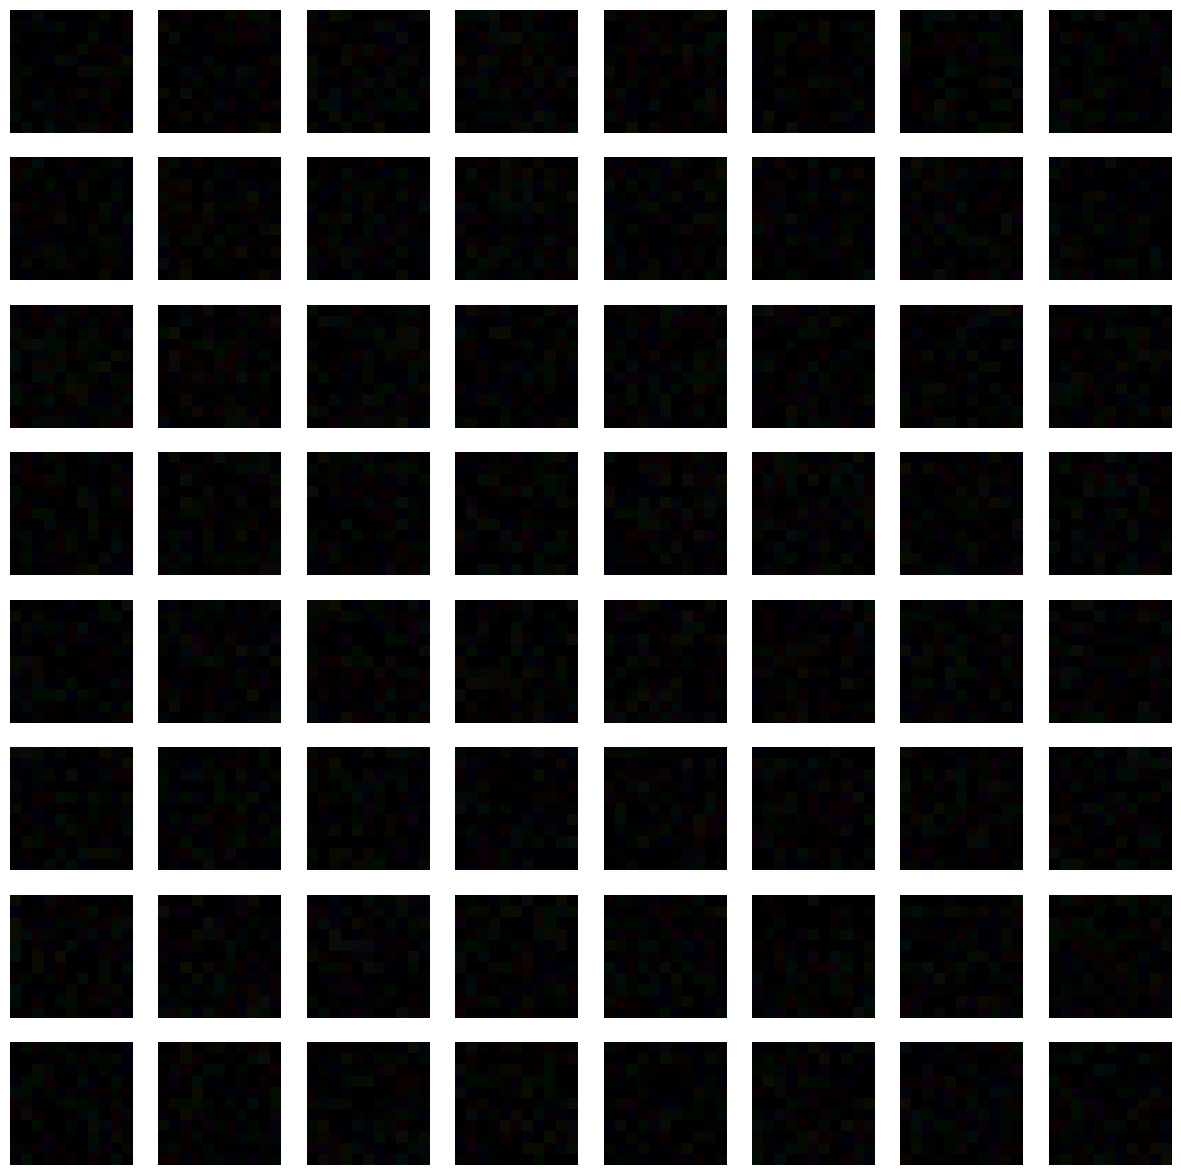

In [20]:
untrained_conv_layer = alexnet.features[0]
plot_first_layer_filters(untrained_conv_layer, nrows=8, ncols=8)

Clearly, the model learned these funky kernels. Let's see what they do to a nice starting image. (Code to load an image from a URL from [here](https://stackoverflow.com/questions/7391945/how-do-i-read-image-data-from-a-url-in-python).)

In [21]:
url = "https://static01.nyt.com/images/2021/09/14/science/07CAT-STRIPES/07CAT-STRIPES-mediumSquareAt3X-v2.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224,224))])
img = transform(img)
print(img.shape)

torch.Size([3, 224, 224])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Let's plot the image we just loaded. Feel free to find your own image and plug it in!

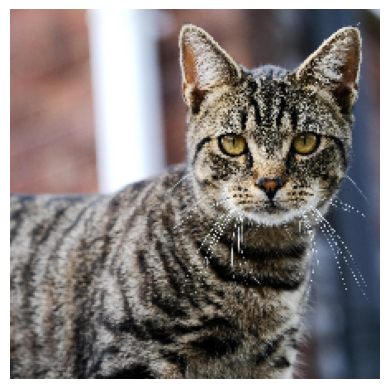

In [27]:
# Permute  (# channels, height, width) -> (height, width # channels)
plt.imshow(img.permute(1,2,0))
plt.axis('off')
plt.show()

Now we can pass the image through the first layer of the image and see what happens.

In [23]:
out = trained_conv_layer(img).detach()
print(out.shape)

torch.Size([64, 55, 55])


We have $64$ channels each of dimension $55 \times 55$. By checking the model statistics that we saw earlier from `torchsummary` we can see why there are $64$ different channels.

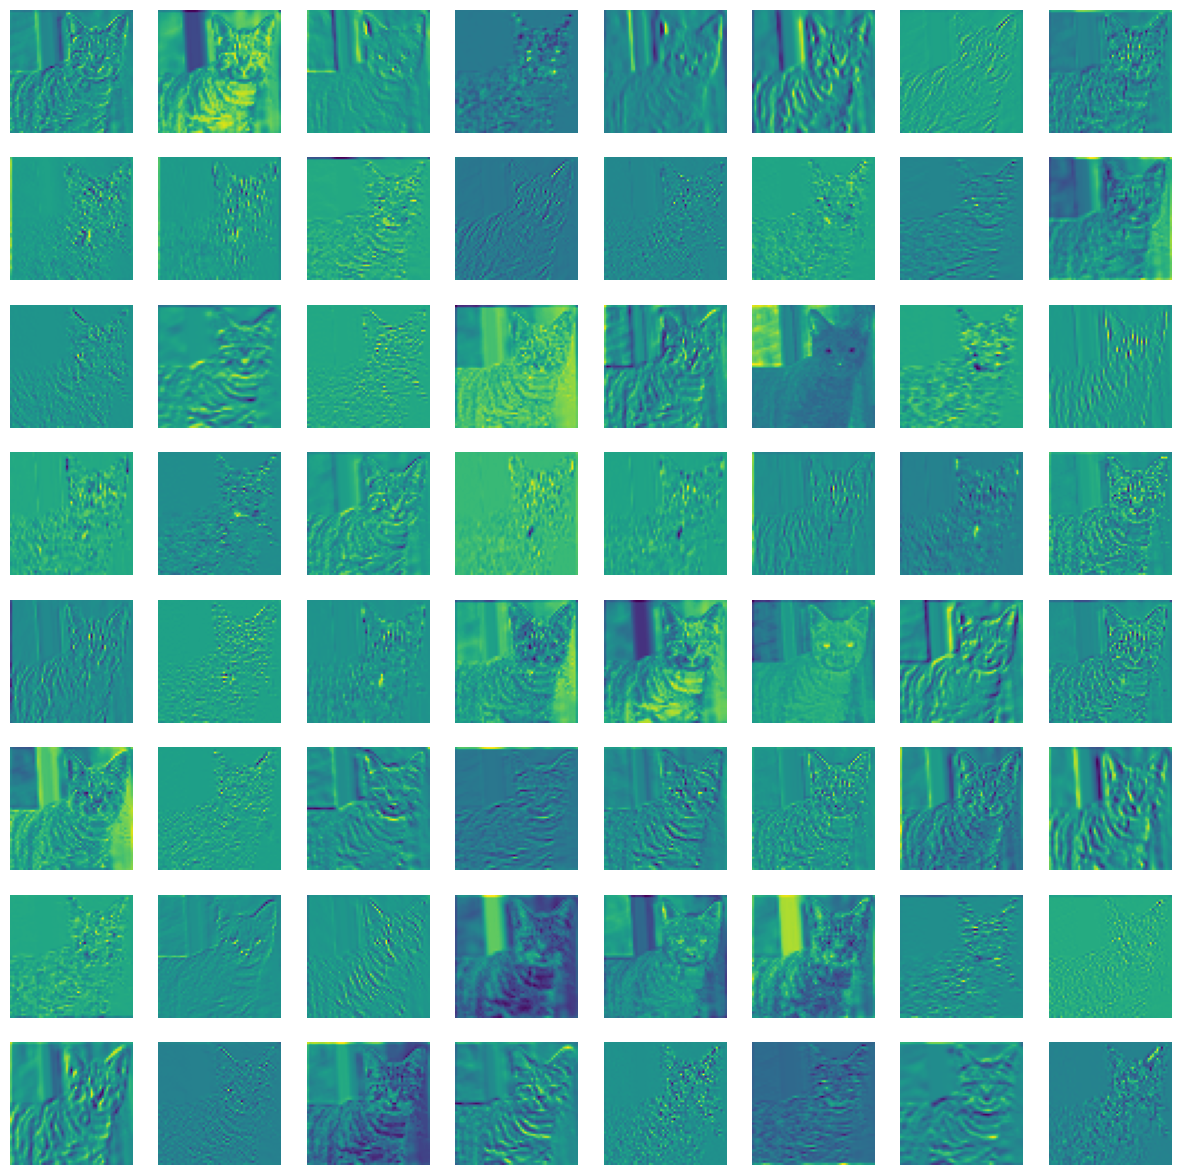

In [24]:
plot_first_layer_activations(out, nrows=8, ncols=8)

Each one of the activations extracts a different set of information from the underlying image. Some detect edges, some detect variation, some detect stripes, some detect circles.

Can you match the resulting output channel to the kernel that created it?